# Run Patch Classifier

In [1]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow import keras

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, band_descriptions
from scripts.viz_tools import *

%load_ext autoreload
%autoreload 2

## Load Model

In [2]:
model = keras.models.load_model('../models/v1.1.0_200_4-23-21_patch_classifier_45px_patch.h5')
input_width = model.input_shape[1]

# Get model input size in degrees
rect_width = np.round((input_width / 100) / 111.32, 4)

## Download Candidate Site Patches

In [17]:
# Load coordinates from the detect_candidates output
filename = 'Nusa_Tenggara_v1.1.5_2020_candidates_pred-thresh_0.95_min-sigma_5_area-thresh_0.005'
candidate_sites = pd.read_csv('../data/model_outputs/candidate_sites/' + filename + '.csv')
candidate_coords = [[lon, lat] for lat, lon in zip(list(candidate_sites['lat']), list(candidate_sites['lon']))]
candidate_names = candidate_sites['name']

start_date = '2020-06-01'
num_months = 1
patch_history = get_history(candidate_coords, 
                            candidate_names, 
                            rect_width,
                            num_months = num_months,
                            start_date = start_date,
                            cloud_mask=True)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [21:10<00:00, 1270.06s/it]


In [18]:
dates = list(patch_history.keys())
sites = list(patch_history[dates[0]].keys())

cloud_threshold = 0.05
cloud_free_sites = []
for site in sites:
    site_cloudiness = []
    for date in dates:
        cloudiness = np.mean([np.sum(patch_history[date][site][band] < 0) / np.size(patch_history[date][site][band]) for band in band_descriptions])
        site_cloudiness.append(cloudiness)
    #print(site, "min clouds:", np.min(site_cloudiness))
    if np.min(site_cloudiness) < cloud_threshold:
        cloud_free_sites.append(site)
print(f"{len(cloud_free_sites) / (len(sites)):.0%} percent of sites have less than {cloud_threshold:.0%} cloud cover")

97% percent of sites have less than 5% cloud cover


## Run Network and Visualize Predictions

In [19]:
patches = np.array(create_img_stack_mean(patch_history, cloud_threshold))
patches = [patch[:input_width, :input_width] for patch in patches]
rgb_img = create_rgb(patches)
patches = normalize(patches)
preds = model.predict(patches)[:,1]

../scripts/viz_tools.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(mean_stack)


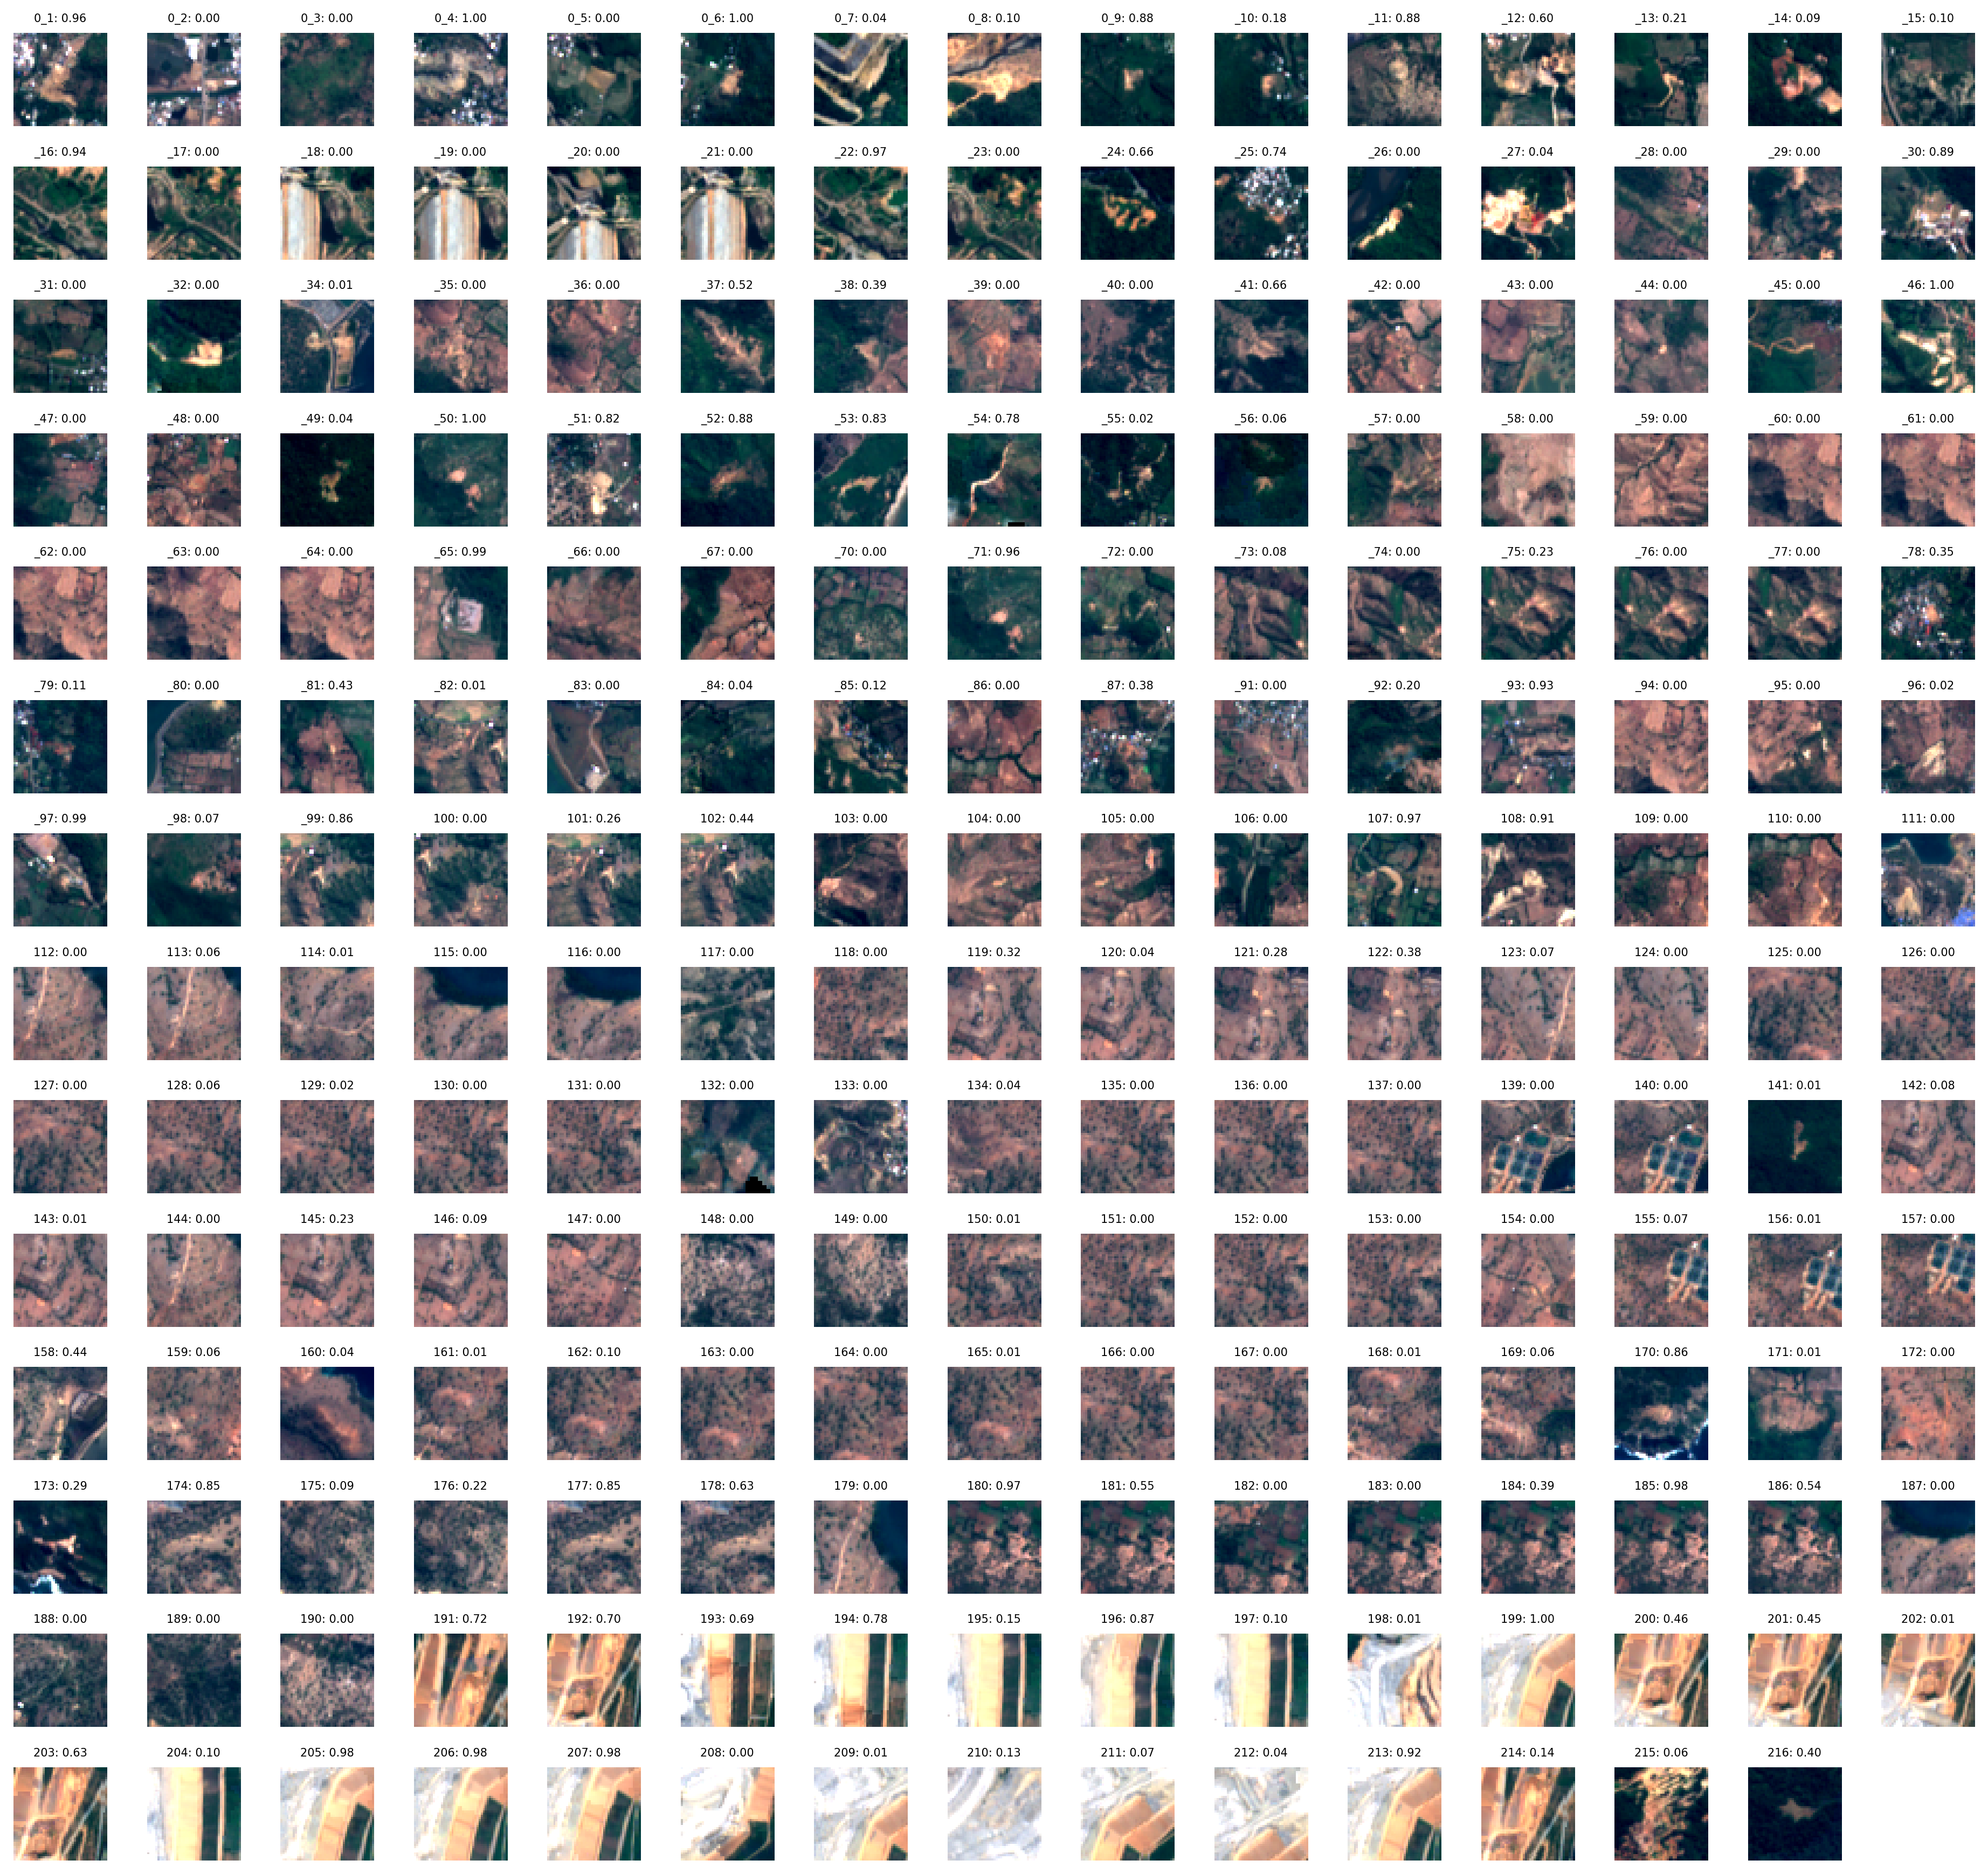

In [20]:
num_img = int(np.ceil(np.sqrt(len(preds))))
plt.figure(figsize=(num_img, num_img), dpi=250, facecolor=(1,1,1))
for index, img in enumerate(rgb_img):
    plt.subplot(num_img, num_img, index + 1)
    plt.imshow(stretch_histogram(img))
    plt.title(f"{cloud_free_sites[index][-3:]}: {preds[index]:.2f}", size=6)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Write Candidate Sites

In [21]:
threshold = 0.1

candidate_sites['patch_prediction'] = [-1] * len(candidate_sites)
for site, pred in zip(cloud_free_sites, preds):
    candidate_sites.loc[candidate_sites['name'] == site, 'patch_prediction'] = pred

# Write only sites with predictions greater than a threshold, or with a value of -1 (no data)
filtered_candidate_sites = candidate_sites.query(f'patch_prediction > {threshold} or patch_prediction == -1')
print(f"{len(filtered_candidate_sites)} / {len(preds)} sites found above the threshold of {threshold}")
filtered_candidate_sites.to_csv(f'../data/model_outputs/candidate_sites/{filename}v1.1.0_200_patch_classifier_thresh_{threshold}.csv', index=False)

80 / 209 sites found above the threshold of 0.1


In [22]:
filtered_candidate_sites

,lon,lat,name,patch_prediction
0,118.748966,-8.483312,Nusa_Tenggara_v1.1.5_2020_1,0.956800
3,118.735825,-8.463419,Nusa_Tenggara_v1.1.5_2020_4,0.998357
5,116.828574,-8.773274,Nusa_Tenggara_v1.1.5_2020_6,0.996981
8,117.001944,-8.510455,Nusa_Tenggara_v1.1.5_2020_9,0.883186
9,116.848694,-8.681831,Nusa_Tenggara_v1.1.5_2020_10,0.182160
...,...,...,...,...
206,116.887301,-8.988876,Nusa_Tenggara_v1.1.5_2020_207,0.984078
209,116.884038,-8.984073,Nusa_Tenggara_v1.1.5_2020_210,0.134272
212,116.887301,-8.987698,Nusa_Tenggara_v1.1.5_2020_213,0.917339
213,116.894415,-8.976506,Nusa_Tenggara_v1.1.5_2020_214,0.143187


In [23]:
kepler_config = {
  "version": "v1",
  "config": {
     "visState": {
      "filters": [],
      "layers": [
        {
          "id": "iik903a",
          "type": "point",
          "config": {
            "dataId": "Candidate Sites",
            "label": "Point",
            "color": [
              218,
              0,
              0
            ],
            "columns": {
              "lat": "lat",
              "lng": "lon",
              "altitude": None
            },
            "isVisible": True,
            "visConfig": {
              "radius": 30,
              "fixedRadius": False,
              "opacity": 0.82,
              "outline": True,
              "thickness": 3,
              "strokeColor": None,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radiusRange": [
                0,
                20
              ],
              "filled": False
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 10,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": None,
            "colorScale": "quantile",
            "strokeColorField": {
              "name": "patch_prediction",
              "type": "real"
            },
            "strokeColorScale": "quantile",
            "sizeField": None,
            "sizeScale": "linear"
          }
        }
      ],
    },
    "mapStyle": {
      "styleType": "satellite",
    }
  }
}

In [24]:
# Plot blob locations on a satellite base image
from keplergl import KeplerGl

candidate_map = KeplerGl(height=800, config=kepler_config)
candidate_map.add_data(data=filtered_candidate_sites, name='Candidate Sites')
#candidate_map.add_data(data=candidate_sites, name='Candidate Sites')
candidate_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'iik903a', 'type': …